In [110]:
import midynet
import midynet.util.display as display
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import fractions
import json

from matplotlib.lines import Line2D
from thresholds import *

display.setup_dir("./")

plot = midynet.metrics.Statistics.plot

paths_to_figures = [".", "../../../../papers/p-midynet/paper1-mutual_info/figures"]
paths_to_figures = list(map(pathlib.Path, paths_to_figures))
path_to_data = pathlib.Path("../../../../data/midynet-data/figure4")

def derivativeOnePoint(x, y):
    y_m = y[:-1]
    y_p = y[1:]
    
    x_m = x[:-1]
    x_p = x[1:]
    
    return (y_p - y_m) / (x_p - x_m)

# def derivativeTwoPoints(x, y):
#     y_0 = y[:-2]
#     y_1 = y[1:-1]
#     y_2 = y[2:]
    
#     x_0 = x[:-2]
#     x_1 = x[1:-1]
#     x_2 = x[2:]
    
#     return (y_2 - y_m) / (x_p - x_m)
    
    

def isolateDuality(x, recon, pred, derFunc=None):
    derFunc = derivativeOnePoint if derFunc is None else derFunc
    derRecon = derFunc(x, recon)
    derPred = derFunc(x, pred)
    return np.where(derRecon * derPred < 0)


In [111]:
exp = {}
hg, hx, hgx, hxg, mi = {}, {}, {}, {}, {}
_hx, _hgx, _mi = {}, {}, {}
thresholds = {}
T = 1000

all_dynamics = ["ising", "sis", "cowan"]
for dynamics in all_dynamics:
    path = path_to_data / f"figure4-large-nbinom-{dynamics}.num_steps{T}"
    print(dynamics, (path / "config.pickle"), (path / "config.pickle").exists())
    if (path / "config.pickle").exists():
        exp[dynamics] = midynet.experiments.Experiment.load_from_file(path / "config.pickle")
        hg[dynamics] = midynet.metrics.Statistics({k: exp[dynamics].metrics["mutualinfo"].data[exp[dynamics].name][f"hg-{k}"] for k in ["mid", "high", "low"]})
        hx[dynamics] = midynet.metrics.Statistics({k: exp[dynamics].metrics["mutualinfo"].data[exp[dynamics].name][f"hx-{k}"] for k in ["mid", "high", "low"]})
        hgx[dynamics] = midynet.metrics.Statistics({k: exp[dynamics].metrics["mutualinfo"].data[exp[dynamics].name][f"hgx-{k}"] for k in ["mid", "high", "low"]})
        hxg[dynamics] = midynet.metrics.Statistics({k: exp[dynamics].metrics["mutualinfo"].data[exp[dynamics].name][f"hxg-{k}"] for k in ["mid", "high", "low"]})
        mi[dynamics] = midynet.metrics.Statistics({k: exp[dynamics].metrics["mutualinfo"].data[exp[dynamics].name][f"mi-{k}"] for k in ["mid", "high", "low"]})
        
        _mi[dynamics] = mi[dynamics].clip(min=0)
        _hx[dynamics] = hxg[dynamics] + _mi[dynamics]
        _hgx[dynamics] = hg[dynamics] - _mi[dynamics]
    N, E = exp[dynamics].config.graph.size, exp[dynamics].config.graph.edge_count.state
    heterogeneity = exp[dynamics].config.graph.heterogeneity
#     if isinstance(heterogeneity, (int, float)):
#         heterogeneity = [heterogeneity]
#     avgk = [midynet.util.degree_sequences.nbinom_degreeseq(N, 2 * E / N, h).mean() for h in heterogeneity]
#     if dynamics == "ising" or dynamics == "sis":
#         thresholds[dynamics] = avgk / dominant_eigenvalue(exp[dynamics].config.graph)
#     else:
#         a = exp[dynamics].config.dynamics.a
#         b = exp[dynamics].config.dynamics.eta
#         m = exp[dynamics].config.dynamics.mu
#         thresholds[dynamics], _ = wc_thresholds(a=a, b=b, m=m)
# #         print(avgk / dominant_eigenvalue(exp[dynamics].config.graph))
# #         print([ttt * avgk[0] / dominant_eigenvalue(exp[dynamics].config.graph) for ttt in wc_thresholds(a=a, b=b, m=m)])
#         thresholds[dynamics] *= avgk / dominant_eigenvalue(exp[dynamics].config.graph)
    
with open("thresholds.json", "r") as f:
    thresholds_data = json.load(f)
titles = {"ising": r"Glauber", "sis": r"SIS", "cowan": r"Cowan"}
xlabels = {"ising": r"Coupling $J\langle k \rangle$", "sis": r"Infection rate $\lambda \langle k \rangle$", "cowan": r"Activity gain $\nu\langle k \rangle$"}

ising ../../../../data/midynet-data/figure4/figure4-large-nbinom-ising.num_steps1000/config.pickle True
sis ../../../../data/midynet-data/figure4/figure4-large-nbinom-sis.num_steps1000/config.pickle True
cowan ../../../../data/midynet-data/figure4/figure4-large-nbinom-cowan.num_steps1000/config.pickle True


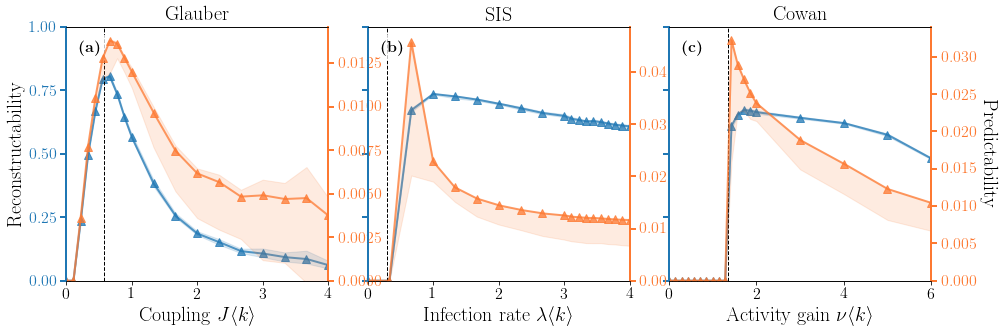

In [115]:
SCALE = 2
fig, ax = plt.subplots(1, 3, figsize=(SCALE*7,SCALE*7/3), sharex=False, sharey=True)

ax = {dynamics: ax[i] for i, dynamics in enumerate(all_dynamics)}
axx = {dynamics: ax[dynamics].twinx() for i, dynamics in enumerate(all_dynamics)}


recon_color = display.med_colors["blue"]
pred_color = display.dark_colors["orange"]


spacing = 7
min_index = 5
recon_yticks = [0, 0.25, 0.5, 0.75, 1.0]
pred_yticks = [0, 0.05, 0.1, 0.15, 0.20]

markers = ["o", "s", "^", "*"]
for dynamics_id, dynamics in enumerate(all_dynamics):
    if dynamics not in exp:
        continue
    z = exp[dynamics].config.graph.heterogeneity
    x = exp[dynamics].config.dynamics.get_coupling()
    if dynamics == "sis":
        x = [c / exp[dynamics].config.dynamics.recovery_prob for c in x]
    m_indices = list(range(min_index)) + list(range(min_index, len(x), spacing))
    recon = _mi[dynamics] / hg[dynamics]
    pred = _mi[dynamics] / _hx[dynamics]
    ymax = -np.inf
    
    z_id = 2
    y = recon if len(x) == 1 else recon
    plot(
        ax[dynamics], 
        x, y,
        color=recon_color,
        alpha=0.75,
        linestyle="-",
        marker=markers[z_id],
        linewidth=1 * SCALE,
        markersize=4 * SCALE,
        bar=False,
        spacing=1,
        interpolate="linear",
    )
    
    y = pred if len(x) == 1 else pred
    if max(y["mid"]) > ymax:
        ymax = max(y["mid"])
    plot(
        axx[dynamics], 
        x, y,
        color=pred_color,
        alpha=0.75,
        linestyle="-",
        marker=markers[z_id],
        linewidth=1 * SCALE,
        markersize=4 * SCALE,
        bar=False,
        spacing=1,
#         error_scaling=5,
        interpolate="linear",
    )
#     dualIndex = isolateDuality(np.array(x), recon["mid"], pred["mid"][:, z_id])[0]
#     minIndex, maxIndex = dualIndex.min(), dualIndex.max()
#     if maxIndex == len(x) - 3:
#         maxIndex = len(x) - 1
#     print(dualIndex)
#     ax[dynamics].axvspan(x[minIndex], x[maxIndex], color=display.light_colors["grey"], alpha=0.5)
    
    
    if dynamics_id == 0:
        ax[dynamics].set_ylabel(r"Reconstructability", fontsize=SCALE * display.fontsizes["large"])
        
    if dynamics_id == len(all_dynamics)-1:
        axx[dynamics].set_ylabel(r"Predictability", fontsize=SCALE * display.fontsizes["large"], rotation=-90, rotation_mode="anchor", va="bottom")
#     else:
#         axx[dynamics].axes.yaxis.set_ticklabels([])
        
    ax[dynamics].set_xlabel(xlabels[dynamics], fontsize=SCALE * display.fontsizes["large"])
    ax[dynamics].tick_params(axis='both', labelsize=SCALE * display.fontsizes["medium"])
    ax[dynamics].set_xlim(min(x), max(x))
    ax[dynamics].set_ylim(0, 1)
    ax[dynamics].set_title(titles[dynamics], fontsize=SCALE * display.fontsizes["large"])
    ax[dynamics].set_yticks(recon_yticks)
    
    axx[dynamics].tick_params(axis='both', labelsize=SCALE * display.fontsizes["medium"])
    axx[dynamics].set_xlim(min(x), max(x))
    axx[dynamics].set_ylim(0, axx[dynamics].get_ylim()[-1])
#     axx[dynamics].set_ylim(0, 0.15)
#     axx[dynamics].set_yticks(pred_yticks)
    
    
    ax[dynamics].tick_params(axis='y', colors=recon_color, length=6, width=2)
    
    axx[dynamics].spines['left'].set_color(recon_color)
    axx[dynamics].spines['left'].set_linewidth(2)
    axx[dynamics].spines['right'].set_color(pred_color)
    axx[dynamics].spines['right'].set_linewidth(2)
    axx[dynamics].tick_params(axis='y', colors=pred_color, length=6, width=2)
    ax[dynamics].axvline(thresholds_data["thresholds"][dynamics], color="black", linestyle="--")
# handles = [
#     Line2D(
#         [0], [0], 
#         marker=markers[i], 
#         linestyle="-", 
#         color=display.dark_colors["grey"], 
#         label=rf"$\Gamma = {fractions.Fraction(z)}$",
#         alpha=0.5,
#         markersize=3 * SCALE,
#         linewidth=1 * SCALE,
#         )
#     for i, z in reversed(list(enumerate(exp[dynamics].config.graph.heterogeneity)))
# ]
# ax["sis"].legend(handles=handles, loc="upper right", fontsize=SCALE * display.fontsizes["medium"], ncol=1, frameon=True)
for dynamics in all_dynamics:
    display.Label.plot(ax[dynamics], loc="top left", fontsize=SCALE * display.fontsizes["medium"], box=True)
display.Label.clear()

# handles = [Line2D([0], [0], marker="None", linestyle="-", color=recon_color, label=r"Reconstructability", alpha=1, linewidth=1)]
# handles += [Line2D([0], [0], marker="None", linestyle="--", color=pred_color, label=r"Predictability", alpha=1, linewidth=1)]
# lg = fig.legend(handles=handles, loc="center", fontsize=display.fontsizes["large"], ncol=2, bbox_to_anchor=(0.5, 1.02))

plt.tight_layout()
plt.subplots_adjust(wspace=0.15)

# for p in paths_to_figures:
#     fig.savefig(p / "svg/p1-figure2.svg", bbox_extra_artists=(lg,), bbox_inches='tight')
#     fig.savefig(p / "pdf/p1-figure2.pdf", bbox_extra_artists=(lg,), bbox_inches='tight')
#     fig.savefig(p / "png/p1-figure2.png", bbox_extra_artists=(lg,), bbox_inches='tight')